In [7]:
!pip install Sastrawi

## Importing Libraries

In [8]:
#Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras import layers
from tensorflow.data import Dataset, AUTOTUNE

In [10]:
#Download the necessary nltk package
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Read The Data

In [11]:
df = pd.read_csv('review_hotel.csv')
df.head()

,review_id,review_text,category
0,0fc651bfdd38a3b4ba19ef9d0d1e92e3,"Penginapannya rapi, bersih, suasana tenang, pe...",1
1,7d8cb2e465c5602e51c1ba8710e8ff16,"wifi tidak sampai kamar, tidak tersedia heater...",0
2,1f4447c73e5e1aac462d05b0ecbd5a55,"Lantai kamar mandi kotor, bau, dan seperti sdh...",0
3,b9aefbfb0debbfff43f8b268c82b43c0,"Wc jorok.. Kasur tidak dibersihkan,, handuk ti...",0
4,e2afef18bd695fae43d4d53b8c547bd4,bocor lagi,0


In [12]:
df.shape

(14856, 3)

In [13]:
df['review_text'].str.findall("(\S+:\S+)").explode().value_counts()

14:00                           4
4:49                            3
00:00                           3
16:00                           2
banget:(                        2
D'paragon:)                     1
pintu:)                         1
aja:(                           1
dicuci:(                        1
instan:(                        1
improve:di                      1
14:00,                          1
16:00.                          1
itu?:(                          1
tidur:))                        1
13:00                           1
18:30-20.00                     1
Terimakasih:)                   1
00:30                           1
23:00                           1
12:09)                          1
17:15                           1
22:00                           1
22:00.                          1
23:00an.                        1
https://youtu.be/6t2Hqf0-HuU    1
15:00                           1
02:00                           1
nya:(                           1
datar..:(     

##Preprocessing

In [14]:
punctuations = re.sub(r"[!<_>#:)\.]", "", string.punctuation)

#Delete some string punctuation
def punct2wspace(text):
    return re.sub(r"[{}]+".format(punctuations), " ", text)

#Delete exsecive space
def normalize_wspace(text):
    return re.sub(r"\s+", " ", text)

#Lowering text
def casefolding(text):
    return text.lower()

def separate_punct(text):
    return re.sub(r"(\w+)(!)", r"\1 \2", text)

#Stemming text
stemfactory = StemmerFactory()
stemmer = stemfactory.create_stemmer()

#Removing Stopwords
stopwordfactory = StopWordRemoverFactory()
stopword = stopwordfactory.create_stop_word_remover()

def preprocess(text):
    text = punct2wspace(text)
    text = normalize_wspace(text)
    text = casefolding(text)
    text = separate_punct(text)
    text = stemmer.stem(text)
    text = stopword.remove(text)
    return text

In [15]:
df["cleaned_text"] = df["review_text"].apply(preprocess)

In [16]:
df['tokenize_text'] = df['cleaned_text'].apply(word_tokenize)

## EDA

In [18]:
df['cleaned_text'].loc[df['category']==1].str.findall("\w+").explode().value_counts()

bersih     777
kamar      755
nyaman     622
hotel      376
layan      366
          ... 
color        1
white        1
sugest       1
stuff        1
balance      1
Name: cleaned_text, Length: 3093, dtype: int64

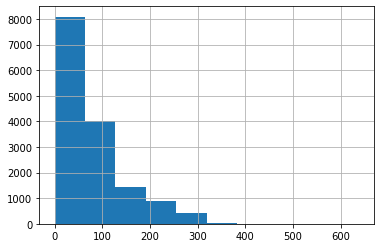

In [30]:
df['cleaned_text'].str.len().hist()

In [19]:
df['cleaned_text'].loc[df['category']==0].str.findall("\w+").explode().value_counts()

kamar       8975
kurang      3418
mandi       2793
air         2748
nya         2666
            ... 
diakalin       1
pegas          1
rembesen       1
arahin         1
social         1
Name: cleaned_text, Length: 9962, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


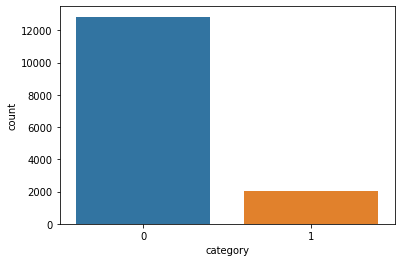

In [20]:
sns.countplot(df['category'])

## Modeling Preparation

In [21]:
xtrain, xtest, ytrain, ytest = train_test_split(df["cleaned_text"],df['category'], test_size=0.2, random_state=5)

In [22]:
train_dataset = Dataset.from_tensor_slices((xtrain, ytrain))
test_dataset = Dataset.from_tensor_slices((xtest, ytest))

train_dataset = train_dataset.batch(32).prefetch(AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(AUTOTUNE)

In [23]:
encoder=layers.TextVectorization(max_tokens=20000)
encoder.adapt(train_dataset.map(lambda feat, tar: feat))

## Modeling

In [24]:
model=Sequential()

model.add(encoder)
model.add(layers.Embedding(
    input_dim=len(encoder.get_vocabulary()), 
    output_dim=16, 
    mask_zero=True))

model.add(layers.LSTM(16, return_sequences=True))
model.add(layers.LSTM(16))

model.add(layers.Dropout(0.3))
model.add(layers.Dense(8))

model.add(layers.Dense(1, activation="sigmoid"))

In [25]:
model.compile(loss="binary_crossentropy", 
              optimizer="rmsprop",
              metrics=["acc"])

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=2)

In [27]:
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=test_dataset,
                    callbacks=[callback])

Epoch 1/15
372/372 [==============================] - 47s 77ms/step - loss: 0.2879 - acc: 0.9101 - val_loss: 0.2042 - val_acc: 0.9398
Epoch 2/15
372/372 [==============================] - 20s 54ms/step - loss: 0.1785 - acc: 0.9449 - val_loss: 0.1867 - val_acc: 0.9441
Epoch 3/15
372/372 [==============================] - 20s 53ms/step - loss: 0.1566 - acc: 0.9504 - val_loss: 0.1762 - val_acc: 0.9462
Epoch 4/15
372/372 [==============================] - 20s 54ms/step - loss: 0.1477 - acc: 0.9528 - val_loss: 0.1739 - val_acc: 0.9478
Epoch 5/15
372/372 [==============================] - 21s 57ms/step - loss: 0.1394 - acc: 0.9552 - val_loss: 0.1739 - val_acc: 0.9468
Epoch 6/15
372/372 [==============================] - 20s 54ms/step - loss: 0.1359 - acc: 0.9560 - val_loss: 0.1745 - val_acc: 0.9482
Epoch 7/15
372/372 [==============================] - 20s 54ms/step - loss: 0.1331 - acc: 0.9567 - val_loss: 0.1758 - val_acc: 0.9465


## Model Evaluation

In [28]:
score=pd.DataFrame(history.history)
score

,loss,acc,val_loss,val_acc
0,0.287915,0.910131,0.204160,0.939771
1,0.178523,0.944884,0.186744,0.944145
2,0.156583,0.950353,0.176234,0.946164
3,0.147716,0.952794,0.173894,0.947847
4,0.139385,0.955234,0.173873,0.946837
5,0.135886,0.955991,0.174491,0.948183
6,0.133074,0.956664,0.175764,0.946501


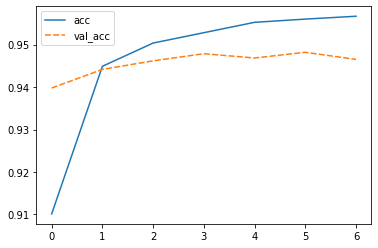

In [29]:
sns.lineplot(data=score[['acc','val_acc']])